In [1]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

下载数据集并指定训练和测试目录

In [2]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
# 将文件的权限设置为 600，文件所有者（root 用户）具有读写权限，而其他用户没有任何权限。
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


下载数据集并解压缩

In [3]:
!kaggle datasets download -d tongpython/cat-and-dog
!unzip cat-and-dog.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: training_set/training_set/cats/cat.3704.jpg  
  inflating: training_set/training_set/cats/cat.3705.jpg  
  inflating: training_set/training_set/cats/cat.3706.jpg  
  inflating: training_set/training_set/cats/cat.3707.jpg  
  inflating: training_set/training_set/cats/cat.3708.jpg  
  inflating: training_set/training_set/cats/cat.3709.jpg  
  inflating: training_set/training_set/cats/cat.371.jpg  
  inflating: training_set/training_set/cats/cat.3710.jpg  
  inflating: training_set/training_set/cats/cat.3711.jpg  
  inflating: training_set/training_set/cats/cat.3712.jpg  
  inflating: training_set/training_set/cats/cat.3713.jpg  
  inflating: training_set/training_set/cats/cat.3714.jpg  
  inflating: training_set/training_set/cats/cat.3715.jpg  
  inflating: training_set/training_set/cats/cat.3716.jpg  
  inflating: training_set/training_set/cats/cat.3717.jpg  
  inflating: training_set/training_set/cats/cat.3718.jpg  
  inflating: training_set/trai

指定训练图像和测试图像文件夹

In [4]:
train_data_dir = 'training_set/training_set'
test_data_dir = 'test_set/test_set'

提供一个为猫狗数据集返回输入-输出对的类（从每个文件夹中获取前500个图像）

In [5]:
class CatsDogs(Dataset):
    # 先通过路径从猫狗文件夹中获取前500个图像、并将它们拼接成一个列表、进行归一化、打乱他们的次序、接着给每张图像打上相应的标签（dog-1.cat-0）
    def __init__(self, folder):
        cats = glob(folder+'/cats/*.jpg')
        dogs = glob(folder+'/dogs/*.jpg')
        # 对 cats 列表进行切片操作，取前 500 个元素。cats 列表包含了文件夹中所有猫图像的文件路径。
        self.fpaths = cats[:500] + dogs[:500]
        # 对张量图像进行归一化。对每个通道的像素值减去均值，然后除以对应通道的标准差。
        # 在图像处理领域，归一化通常用于将图像的像素值限制在一个特定的范围内，例如[0, 1]或[-1, 1]。这可以使模型更容易学习图像的特征，并提高模型的泛化能力。
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        from random import shuffle, seed;
        seed(10);
        shuffle(self.fpaths)
        # 使用列表推导式创建了一个名为 self.targets 的列表，其中存储了每个样本的目标类别。
        # fpath.split('/')[-1]：对于 self.fpaths 中的每个文件路径 fpath，使用 split('/') 方法将路径分割成一个列表，然后取其最后一个元素，即文件名部分。
        # .startswith('dog')：对每个文件名进行检查，判断其是否以 'dog' 开头。如果是，返回 True，否则返回 False。
        self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths]
    def __len__(self): return len(self.fpaths)
    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        # 使用 OpenCV 的 cv2.imread 函数读取图像文件 f，并通过数组切片操作 [:,:,::-1] 将其转换为 RBG 通道顺序（因为 OpenCV 读取的图像默认为 GRB 通道顺序）。
        # 彩色图像，其三个维度通常表示为高度、宽度和通道数
        # 第一个 : 表示选择数组的所有行（高度）。第二个 : 表示选择数组的所有列（宽度）。::-1 表示【逆序选择数组的最后一个维度（通道维度）】。这里数组的最后一个维度通常是通道维度（即 RGB 或 BGR 通道），通过 ::-1 可以将通道顺序逆序排列。对于彩色图像，通道的顺序通常是 BGR（蓝、绿、红），而 ::-1 就是将 BGR 通道顺序颠倒成 RGB（红、绿、蓝）。
        im = (cv2.imread(f)[:,:,::-1])
        im = cv2.resize(im, (224,224))
        # 将调整大小后的图像数据转换为 PyTorch 张量，并将像素值归一化到 [0, 1] 的范围。通常情况下，将像素值归一化到 [0, 1] 或 [-1, 1] 的范围可以帮助模型更好地进行训练。
        im = torch.tensor(im/255)
        # 调用 PyTorch 张量的 permute 方法，将图像张量的维度顺序从 (height, width, channels) 调整为 (channels, height, width)。这是因为 PyTorch 中的张量默认使用 (channels, height, width) 的顺序表示图像数据。
        # 第一个参数 2：表示将原始张量的第三个维度（通道数维度）移动到新张量的第一个位置。这意味着通道数维度现在成为了新张量的第一个维度。
        im = im.permute(2,0,1)
        # 调用之前定义的 self.normalize 变换，对图像张量进行归一化操作。这个操作会减去均值并除以标准差，使得图像数据的均值接近 0，方差接近 1，有助于提高模型训练的稳定性和效果。
        im = self.normalize(im)
        # 将处理后的图像张量转换为浮点类型，并移动到指定的设备上（由 device 变量确定）。同时，将目标类别转换为张量并移动到相同的设备上，并返回图像张量和目标张量作为 __getitem__ 方法的输出。
        return im.float().to(device), torch.tensor([target]).float().to(device)

获取图像数据及其标签

In [6]:
data = CatsDogs(train_data_dir)

检查某个图像样本数据及其对应的类别

tensor([0.])


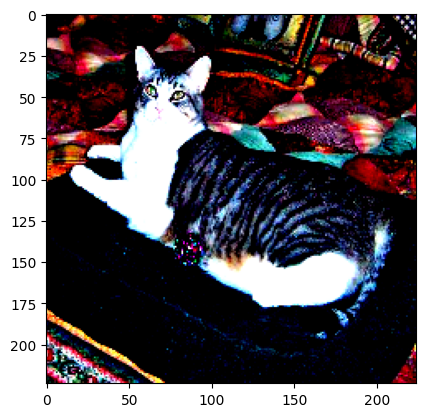

In [7]:
im, label = data[200]
# im.permute(1, 2, 0) 将张量的维度顺序从 PyTorch 默认的 (channels, height, width) 调整为 (height, width, channels)，以适应 imshow() 函数的要求。
plt.imshow(im.permute(1,2,0).cpu())
print(label)

定义模型。下载预训练好的VGG16权重，然后冻结features模块，使用avgpool和classifier模块进行训练

In [8]:
def get_model():
    # 从models类中下载预训练的VGG16模型
    model = models.vgg16(pretrained=True)   #加载预训练的权重
    for param in model.parameters():
        # 为了冻结模型的所有参数，使其在训练过程中不会被更新（在反向传播期间对参数进行冻结）。因为我们会替换模型的最后几层，所以预训练的参数不需要更新。
        param.requires_grad = False
    # 修改了模型的全局平均池化层，将其替换为一个自适应平均池化层，输出大小为 (1, 1)。这样做是为了将任意大小的输入图像转换为固定大小的特征向量，以便输入到后续的全连接层中。
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1)) #batch_size×512×1×1 [batch_size, channel, height, width]
    # 这个分类器的结构适用于二分类任务，输出一个概率值表示样本属于正类的概率。
    model.classifier = nn.Sequential(nn.Flatten(),      #(batch_size, C, H, W) -> (batch_size, C*H*W)
                     nn.Linear(512, 128),
                     nn.ReLU(),
                     nn.Dropout(0.2),     #(正则化)以20%的概率将输入张量的某些元素设置为零。有助于减少神经网络中的过拟合现象，提高模型的泛化能力。
                     nn.Linear(128, 1),
                     nn.Sigmoid())       #将输入值压缩到 0 到 1 之间，用于产生概率值。在二分类任务中，它将输出值解释为样本属于正类的概率。
    loss_fn = nn.BCELoss()  #二元交叉熵损失函数
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)  #学习率为 0.001
    return model.to(device), loss_fn, optimizer

获取模型的摘要信息

In [9]:
!pip install torch_summary
from torchsummary import summary
model, criterion, optimizer = get_model()
# 传入一个示例输入张量是为了让函数了解模型的输入形状。
summary(model, torch.zeros(1,3,224,224))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:14<00:00, 37.9MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

定义用于批训练的函数

In [10]:
def train_batch(x, y, model, opt, loss_fn):
    # 将模型设置为训练模式，这样可以确保模型在训练时正常地使用 Dropout、Batch Normalization 等技术，并且能够记录梯度信息以便后续进行反向传播和参数更新。
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    # 返回批次的损失值。.item() 方法用于获取张量中的单个值，这里用于返回一个 Python 浮点数，表示损失值。
    return batch_loss.item()

定义一个函数，用于计算模型关于批数据的准确度

In [11]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

In [12]:
def get_data():
    train = CatsDogs(train_data_dir)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last = True)
    val = CatsDogs(test_data_dir)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last = True)
    return trn_dl, val_dl

In [13]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [14]:
train_losses, train_accuracies = [], []
val_accuracies = []
for epoch in range(5):
    print(f" epoch {epoch + 1}/5")
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

 epoch 1/5


KeyboardInterrupt: 

In [ ]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with VGG16 \nand 1K training data points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.95,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()